In [1]:
import pandas as pd
from pathlib import Path

a2_df_bone_census_ol_pejeta_western = pd.read_pickle("../data/pkl/a2_df_bone_census_ol_pejeta_western.pkl")
a2_df_bone_census_ol_pejeta_western_rank = pd.read_pickle("../data/pkl/a2_df_bone_census_ol_pejeta_western_rank.pkl")
a2_df_bone_census_ol_pejeta_western_rank.head()

Year,1998,2001,2004,2005,2006,2007,2008,2009,2010,2011,2012,2014,2015,2016,2017,2018,2023
Species,,,,,,,,,,,,,,,,,
Aepyceros melampus,4,6,6,2,8,2,4,7,5,6,7,8,9,7,8,5,2
Alcelaphus buselaphus,4,6,6,2,8,6,4,7,5,6,7,8,13,7,8,10,2
Bos taurus indicus,2,1,6,2,2,9,4,7,5,6,12,8,13,7,8,10,2
Bovidae (large),4,1,2,2,2,2,4,4,5,6,2,5,9,2,4,4,2
Bovidae (medium),2,6,6,1,8,2,1,2,1,2,2,2,2,2,4,5,2


In [2]:
import pandas as pd
import numpy as np

summary = a2_df_bone_census_ol_pejeta_western.copy()

to_rank = (
    summary
    .drop(index="Column_Total", errors="ignore")
    .drop(columns=["Row_Total"], errors="ignore")
)

ranks_wide = to_rank.rank(axis=0, method='min', ascending=False)

# 1) Reciprocal-rank weights (higher rank -> smaller weight)
recip = (1 / ranks_wide).astype(float).fillna(0)

# 2) Normalize within each year so column weights sum to 1 (makes years comparable)
recip_norm = recip.div(recip.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)

# 3) A cross-year dominance score per species (equal weight to each year)
species_recip_score = recip_norm.mean(axis=1).sort_values(ascending=False)

# Optional: “Borda-like” linear rank weights, also normalised per year
max_rank_per_year = ranks_wide.max(skipna=True)
borda = (max_rank_per_year - ranks_wide + 1)  # top rank gets largest weight
borda_norm = borda.div(borda.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
species_borda_score = borda_norm.mean(axis=1).sort_values(ascending=False)

borda.head()

Year,1998,2001,2004,2005,2006,2007,2008,2009,2010,2011,2012,2014,2015,2016,2017,2018,2023
Species,,,,,,,,,,,,,,,,,
Aepyceros melampus,1.0,1.0,1.0,1.0,1.0,8.0,1.0,1.0,1.0,1.0,6.0,1.0,5.0,1.0,1.0,6.0,1.0
Alcelaphus buselaphus,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0
Bos taurus indicus,3.0,6.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Bovidae (large),1.0,6.0,5.0,1.0,7.0,8.0,1.0,4.0,1.0,1.0,11.0,4.0,5.0,6.0,5.0,7.0,1.0
Bovidae (medium),3.0,1.0,1.0,2.0,1.0,8.0,4.0,6.0,5.0,5.0,11.0,7.0,12.0,6.0,5.0,6.0,1.0


In [3]:
species_borda_score.head(50)

Species
Equus burchellii           0.136112
Bovidae (medium)           0.099969
Bovidae (large)            0.083142
Giraffa camelopardalis     0.064316
Phacochoerus africanus     0.061492
Syncerus caffer            0.059793
Bovidae (small)            0.059308
Taurotragus                0.049909
Nanger granti              0.044162
Bos taurus indicus         0.043609
Kobus ellipsiprymnus       0.043385
Aepyceros melampus         0.041079
Eudorcas thomsonii         0.033606
Loxodonta africana         0.032727
Alcelaphus buselaphus      0.031380
Dendrohyrax arboreus       0.029573
Chlorocebus pygerythrus    0.029573
Panthera leo               0.029112
Hyaenidae                  0.027753
dtype: float64

In [5]:
# Proportional abundances per year
prop = to_rank.div(to_rank.sum(axis=0).replace(0, np.nan), axis=1)

# Shannon diversity H' and Pielou evenness J' per year
H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0)
S = (to_rank > 0).sum(axis=0)                    # richness
J = H / np.log(S.replace(0, np.nan))

# Bray–Curtis dissimilarity needs pairwise comparisons; Spearman rank corr for rank stability:
spearman_by_year = to_rank.corr(method='spearman')  # columns = years
prop.head()

Year,1998,2001,2004,2005,2006,2007,2008,2009,2010,2011,2012,2014,2015,2016,2017,2018,2023
Species,,,,,,,,,,,,,,,,,
Aepyceros melampus,0.00,0.00,0.000000,0.0,0.000000,0.074074,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.027027,0.0,0.000000,0.052632,0.0
Alcelaphus buselaphus,0.00,0.00,0.000000,0.0,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Bos taurus indicus,0.25,0.25,0.000000,0.0,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
Bovidae (large),0.00,0.25,0.214286,0.0,0.083333,0.074074,0.000000,0.083333,0.000000,0.000000,0.125000,0.055556,0.027027,0.1,0.085714,0.105263,0.0
Bovidae (medium),0.25,0.00,0.000000,1.0,0.000000,0.074074,0.333333,0.250000,0.333333,0.181818,0.125000,0.166667,0.081081,0.1,0.085714,0.052632,0.0


In [6]:
abund = a2_df_bone_census_ol_pejeta_western

In [7]:
def diversity_metrics(abund: pd.DataFrame) -> pd.DataFrame:
    # proportions per year
    col_sums = abund.sum(axis=0)
    prop = abund.div(col_sums.replace(0, np.nan), axis=1)

    # richness (Hill N0)
    S = (abund > 0).sum(axis=0)

    # Shannon (H'), Hill N1 = exp(H')
    H = -(prop * np.log(prop.replace(0, np.nan))).sum(axis=0).fillna(0)
    N1 = np.exp(H)

    # Simpson D = sum p^2, Hill N2 = 1/D
    D = (prop ** 2).sum(axis=0).fillna(0)
    N2 = (1 / D.replace(0, np.nan)).fillna(0)

    # Evenness: Pielou J' and Hill evenness (N1/S)
    J = (H / np.log(S.replace(0, np.nan))).fillna(0)
    E_hill = (N1 / S.replace(0, np.nan)).fillna(0)

    out = pd.DataFrame({
        "Richness_S": S,
        "Shannon_H'": H,
        "Hill_N1": N1,
        "Simpson_D": D,
        "Hill_N2": N2,
        "Pielou_J'": J,
        "Hill_evenness_N1_over_S": E_hill,
        "Total_Abundance": col_sums
    })
    out.index.name = "Year"
    return out

metrics = diversity_metrics(abund)
metrics.round(3).head(50)

,Richness_S,Shannon_H',Hill_N1,Simpson_D,Hill_N2,Pielou_J',Hill_evenness_N1_over_S,Total_Abundance
Year,,,,,,,,
1998,4,1.213,3.364,0.344,2.909,0.875,0.841,8
2001,6,1.473,4.362,0.305,3.282,0.822,0.727,16
2004,6,1.359,3.892,0.332,3.015,0.758,0.649,28
2005,2,0.693,2.000,0.500,2.000,1.000,1.000,2
2006,8,1.488,4.427,0.323,3.097,0.715,0.553,24
2007,9,1.417,4.124,0.344,2.904,0.645,0.458,54
2008,4,1.242,3.464,0.333,3.000,0.896,0.866,6
2009,7,1.509,4.524,0.306,3.273,0.776,0.646,24
2010,5,1.358,3.888,0.319,3.130,0.844,0.778,12


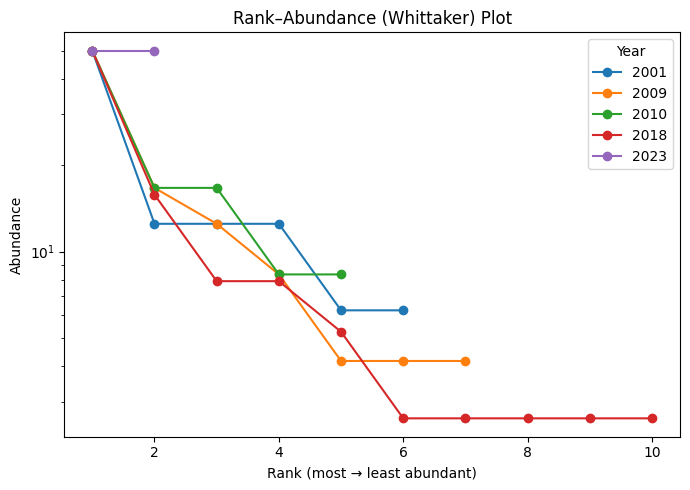

In [8]:
import matplotlib.pyplot as plt

def whittaker_plot(abund: pd.DataFrame, years=None, log_y=True):
    """
    Draws rank–abundance curves. One curve per year.
    """
    if years is None:
        years = list(abund.columns)

    plt.figure(figsize=(7, 5))
    for yr in years:
        s = abund[yr]
        s = s[s > 0].sort_values(ascending=False)  # positive abundances only
        if s.empty:
            continue
        ranks = np.arange(1, len(s) + 1)
        plt.plot(ranks, s.values, marker="o", label=str(yr))

    plt.xlabel("Rank (most → least abundant)")
    plt.ylabel("Abundance")
    if log_y:
        plt.yscale("log")  # classic Whittaker uses log-abundance
    plt.title("Rank–Abundance (Whittaker) Plot")
    plt.legend(title="Year")
    plt.tight_layout()
    plt.show()

# Example: plot a few years (or omit 'years=' to plot all)
#whittaker_plot(abund, years=[2005, 2009, 2017, 2023], log_y=True)
#whittaker_plot(prop*100, years=[2009, 2023], log_y=False)
#whittaker_plot(abund, years=[2008, 2019], log_y=True)
#whittaker_plot(abund, years=[2009, 2010, 2019, 2023], log_y=True)
prop = abund.div(abund.sum(axis=0).replace(0, np.nan), axis=1).fillna(0)
whittaker_plot(prop*100, years=[2001, 2009, 2010, 2018, 2023], log_y=True)